## Web Voyager

[WebVoyager](https://arxiv.org/abs/2401.13919) by He, et. al., is a vision-enabled web-browsing agent capable of controlling the mouse and keyboard.

It works by viewing browser screenshots for each turn and choosing the next step to take. The agent architecture is a basic Reasoning and action (ReAct) loop. The unique aspect of this agent is the use of a vision model in the agent, and the use of bounding box annotations to assist its interactions with the browser.

![Voyager Image](./img/paper_figure.png)

Below is an implementation of it in LangGraph:

In [1]:
# %pip install -U --quiet langchain langchain_core langchain_openai

In [2]:
# %pip install --upgrade --quiet  playwright > /dev/null
# %pip install --upgrade --quiet  lxml
# !playwright install

In [3]:
from asyncio_nb_utils import apply

apply()

## Define tools

The agent has 6 simple tools:

1. Click (at labeled box)
2. Type
3. Scroll
4. Wait
5. Go back
6. Go to search engine (Google)


We define them below here.

In [4]:
import asyncio
import platform


async def click(state):
    # - Click [Numerical_Label]
    page = state["page"]
    click_args = state["prediction"]["args"]
    if click_args is None or len(click_args) != 1:
        return f"Failed to click bounding box labeled as number {click_args}"
    bbox_id = click_args[0]
    bbox_id = int(bbox_id)
    bbox = state["bboxes"][bbox_id - 1]  # 1-indexed
    x, y = bbox["x"], bbox["y"]
    res = await page.mouse.click(x, y)
    # TODO: In the paper, they automatically parse any downloaded PDFs
    # We could add something similar here as well and generally
    # improve response format.
    return f"Clicked {bbox_id}"


async def type_text(state):
    page = state["page"]
    type_args = state["prediction"]["args"]
    if type_args is None or len(type_args) != 2:
        return (
            f"Failed to type in element from bounding box labeled as number {type_args}"
        )
    bbox_id = type_args[0]
    bbox_id = int(bbox_id)
    bbox = state["bboxes"][bbox_id]  # - 1]  # 1-indexed
    x, y = bbox["x"], bbox["y"]
    text_content = type_args[1]
    await page.mouse.click(x, y)
    # Check if MacOS
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(text_content)
    await page.keyboard.press("Enter")
    return f"Typed {text_content} and submitted"


async def scroll(state):
    page = state["page"]
    scroll_args = state["prediction"]["args"]
    if scroll_args is None or len(scroll_args) != 2:
        return "Failed to scroll due to incorrect arguments."

    target, direction = scroll_args

    if target.upper() == "WINDOW":
        # Not sure the best value for this:
        scroll_amount = 500
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        # Scrolling within a specific element
        scroll_amount = 200
        target_id = int(target)
        bbox = state["bboxes"][target_id - 1]  # 1-indexed
        x, y = bbox["x"], bbox["y"]
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"


async def wait(state):
    sleep_time = 5
    asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time}s."


async def go_back(state):
    page = state["page"]
    await page.go_back()
    return f"Navigated back a page to {page.url}."


async def to_google(state):
    page = state["page"]
    await page.goto("https://www.google.com/")
    return "Navigated to google.com."

## Define Agent

Our agent chain is composed of:

1. A `mark_page` function to annotate the current page with bounding boxes
2. A prompt to hold the user question, annotated image, and agent scratchpad
3. GPT-4V to decide the next steps
4. Parsing logic to extract the action

#### Browser Annotations

This function annotates all buttons, inputs, text areas, etc. with numbered bounding boxes. GPT-4V then just has to refer to a bounding box
when taking actions, reducing the complexity of the overall task.

In [5]:
import asyncio
import base64

from IPython import display
from langchain_core.runnables import chain as chain_decorator

# Some javascript we will run on each step
# to take a screenshot of the page, select the
# elements to annotate, and add bounding boxes
with open("mark_page.js") as f:
    mark_page_script = f.read()


@chain_decorator
async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range(10):
        try:
            bboxes = await page.evaluate("markPage()")
            break
        except:
            # May be loading...
            asyncio.sleep(3)
    screenshot = await page.screenshot()
    # Ensure the bboxes don't follow us around
    await page.evaluate("unmarkPage()")
    return {
        "img": base64.b64encode(screenshot).decode(),
        "bboxes": bboxes,
    }

#### Agent definition

In [14]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI


async def enter(state):
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    return {**state, **marked_page}


def parse(text: str) -> dict:
    action_prefix = "Action: "
    if not text.strip().split("\n")[-1].startswith(action_prefix):
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    action_block = text.strip().split("\n")[-1]

    action_str = action_block[len(action_prefix) :]
    split_output = action_str.split(" ", 1)
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else:
        action, action_input = split_output
    action = action.strip()
    if action_input is not None:
        action_input = [
            inp.strip().strip("[]") for inp in action_input.strip().split(";")
        ]
    return {"action": action, "args": action_input}


# Will need a later version of langchain to pull
# this image prompt template
prompt = hub.pull("wfh/web-voyager")

In [15]:
llm = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=4096)
agent = enter | RunnablePassthrough.assign(
    prediction=prompt | llm | StrOutputParser() | parse
)

## Define Graph

First, determine the state that ought to be tracked between nodes.

In [16]:
from typing import List, Optional, TypedDict

from langchain_core.messages import BaseMessage, SystemMessage
from langchain_core.runnables import RunnableLambda
from langgraph.graph import END, StateGraph
from playwright.async_api import Page


class BBox(TypedDict):
    x: float
    y: float


class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]


# This represents the state of the agent
# as it proceeds through execution
class AgentState(TypedDict):
    page: Page  # The Playwright web page lets us interact with the web environment
    input: str  # User request
    img: str  # b64 encoded screenshot
    bboxes: List[BBox]  # The bounding boxes from the browser annotation function
    prediction: Prediction  # The Agent's output
    scratchpad: List[
        BaseMessage
    ]  # A system message (or messages) containing the intermediate steps
    observation: str  # The most recent response from a tool

#### Create graph

In [18]:
import re

graph_builder = StateGraph(AgentState)


def update_scratchpad(state: AgentState):
    """After a tool is invoked, we want to update
    the scratchpad so the agent is aware of its previous steps"""
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['observation']}"

    return {**state, "scratchpad": [SystemMessage(content=txt)]}


graph_builder.add_node("agent", agent)
graph_builder.set_entry_point("agent")
graph_builder.add_node("update_scratchpad", update_scratchpad)
graph_builder.add_edge("update_scratchpad", "agent")

tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "GoBack": go_back,
    "Google": to_google,
}


for node_name, tool in tools.items():
    graph_builder.add_node(
        node_name,
        RunnableLambda(tool) | (lambda observation: {"observation": observation}),
    )
    # Always return to the agent
    graph_builder.add_edge(node_name, "update_scratchpad")


def select_tool(state: AgentState):
    action = state["prediction"]["action"]
    if action == "ANSWER":
        return END
    if action == "retry":
        return "agent"
    return action


graph_builder.add_conditional_edges("agent", select_tool)

graph = graph_builder.compile()

## Run agent

In [35]:
from langchain_community.tools.playwright.utils import (
    create_async_playwright_browser,  # A synchronous browser is available, though it isn't compatible with jupyter.\n",      },
)

browser = create_async_playwright_browser(headless=False)
page = await browser.new_page()
_ = await page.goto("https://www.google.com")

In [20]:
async def call_agent(question: str, page, max_steps: int = 150):
    event_stream = graph.astream(
        {
            "page": page,
            "input": question,
            "scratchpad": [],
        },
        {
            "recursion_limit": max_steps,
        },
    )
    final_answer = None
    steps = []
    async for event in event_stream:
        # We'll display an event stream here
        if "agent" not in event:
            continue
        pred = event["agent"].get("prediction") or {}
        action = pred.get("action")
        action_input = pred.get("args")
        display.clear_output(wait=False)
        steps.append(f"{len(steps) + 1}. {action}: {action_input}")
        print("\n".join(steps))
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))
        if "ANSWER" in action:
            final_answer = action_input[0]
            break
    return final_answer

1. Type: ['9', 'langchain blog']
2. Click: ['25']
3. ANSWER;: ['The latest blog posts from LangChain include "OpenGPTs," "LangGraph: Multi-Agent Workflows," "LangGraph," and "LangChain v0.1.0."']


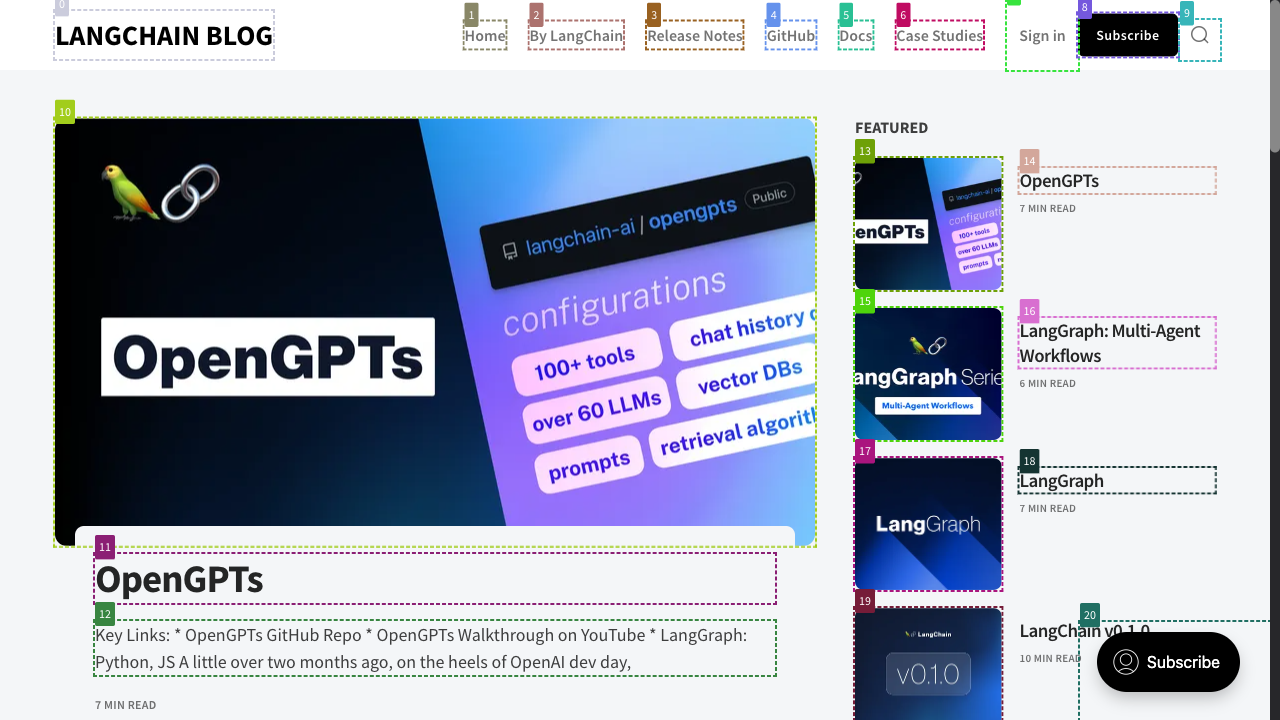

Final response: The latest blog posts from LangChain include "OpenGPTs," "LangGraph: Multi-Agent Workflows," "LangGraph," and "LangChain v0.1.0."


In [12]:
res = await call_agent("What are the latest blog posts from langchain?", page)
print(f"Final response: {res}")

1. Type: ['9', "today's XKCD comic"]
2. Click: ['25']
3. retry: Could not parse LLM Output: The comic from XKCD you are referring to appears to be a satirical take on the US survey foot, which is an older unit of length used in the United States. The comic mentions that the US survey foot was deprecated by the National Institute of Standards and Technology (NIST) in 2023, suggesting that this unit of measurement is no longer officially recognized or recommended for use.

The humor in the comic comes from the exaggerated distress and dramatic narrative about the reintroduction of the US survey foot, depicted as a problematic event. The comic plays on the idea that some people might resist change or cling to outdated standards (the US survey foot), even when a more standardized measurement (the international foot) exists. The punchline, "SOMEONE has started using THE US SURVEY FOOT AGAIN," suggests a needless return to a complicated system, and the final panel jokingly implies that such 

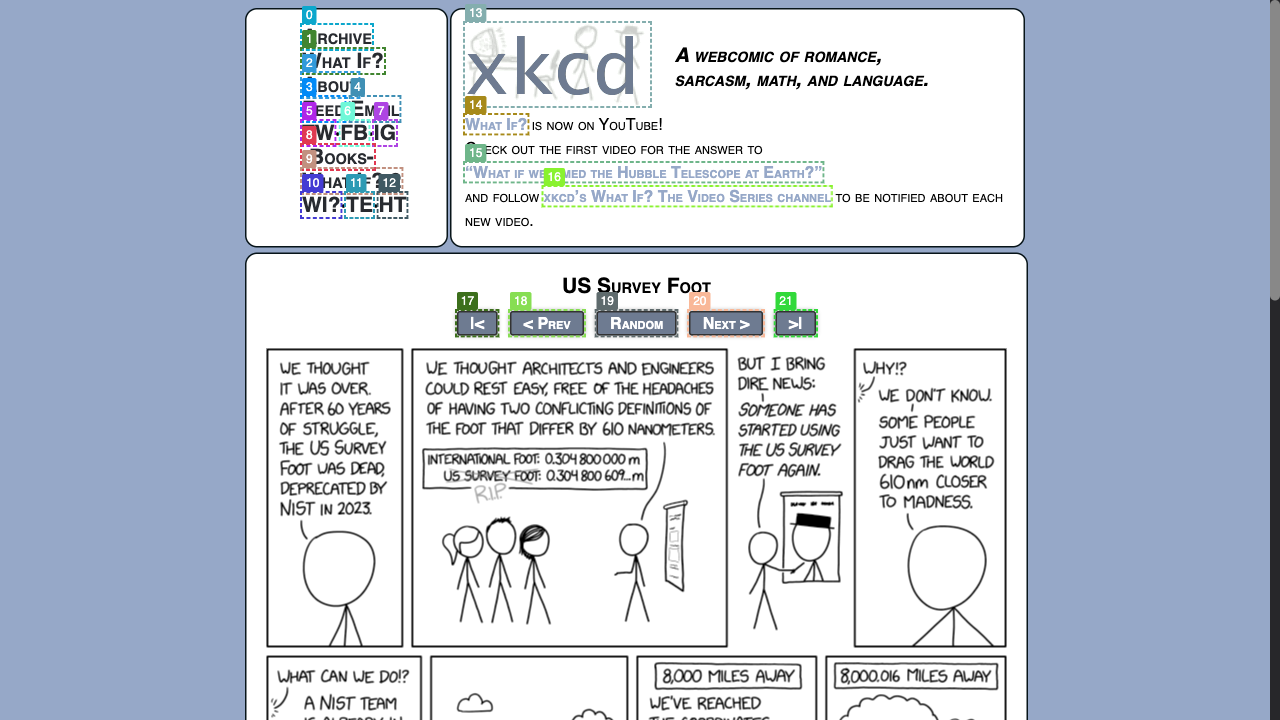

Final response: The XKCD comic is commenting on the US survey foot, which was an alternate form of the foot measurement used in the United States. The comic jokes that after years of struggle to eliminate the use of this non-standard unit, which was officially deprecated by the National Institute of Standards and Technology (NIST) in 2023, someone has started using the US survey foot again. The humor lies in the absurdity of reverting to a deprecated measurement for no apparent reason other than, as the comic suggests, to bring the world "610 nanometers closer to madness." It's funny because it plays on the frustration of those who advocate for the use of standard units of measurement and the futility of having two slightly different definitions for the same unit.


In [21]:
res = await call_agent(
    "Please explain the today's XKCD comic for me. Why is it funny?", page
)
print(f"Final response: {res}")

1. Google: None
2. Type: ['8', 'Web Voyager paper arxiv']
3. Click: ['24']
4. GoBack: None
5. Click: ['24']
6. GoBack: None
7. Click: ['29']
8. Click: ['32']
9. ANSWER;: ['The Web Voyager paper presents an end-to-end web agent called "WebGPT" which combines large language models with web browsers. This approach aims to enhance the interaction between humans and information on the internet by creating an agent that can effectively perform web browsing tasks. The paper discusses the architecture and functionality of this agent, which includes the ability to generate responses based on the content it retrieves from web browsing. It also addresses the challenges of creating such an agent, such as handling the dynamic nature of web content, and how the WebGPT agent is designed to navigate and understand this ever-changing environment.']


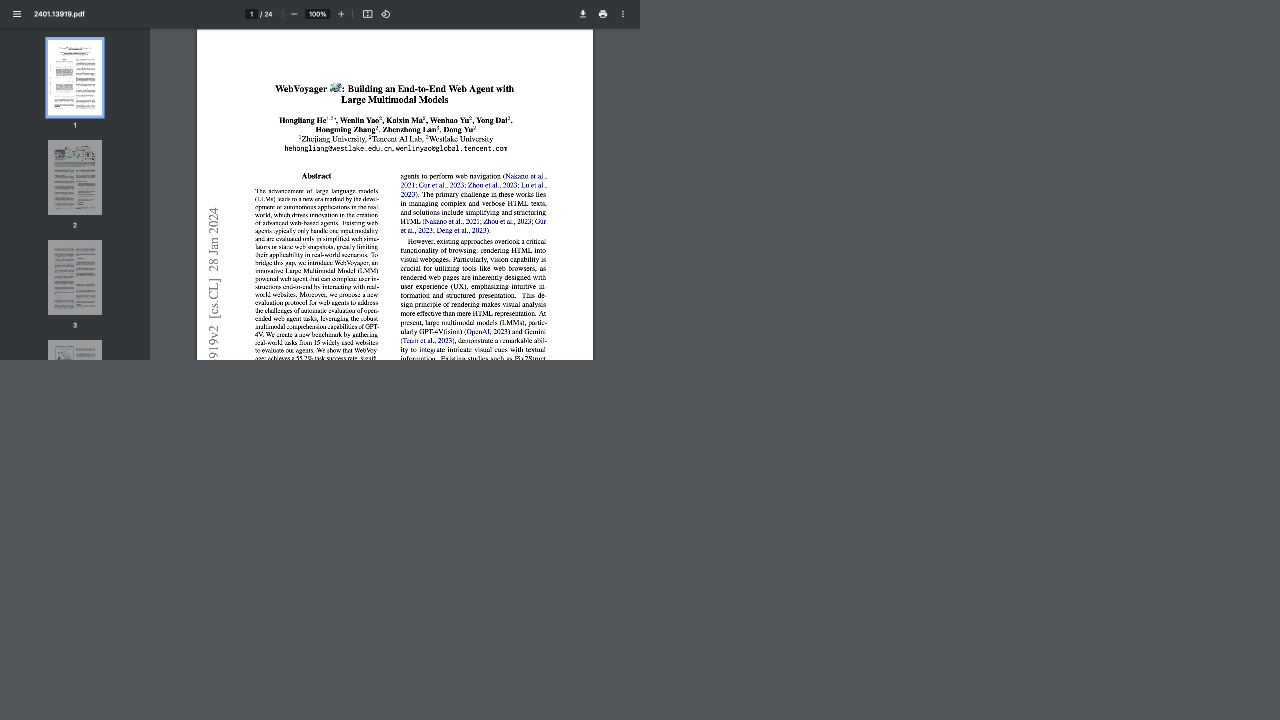

Final response: The Web Voyager paper presents an end-to-end web agent called "WebGPT" which combines large language models with web browsers. This approach aims to enhance the interaction between humans and information on the internet by creating an agent that can effectively perform web browsing tasks. The paper discusses the architecture and functionality of this agent, which includes the ability to generate responses based on the content it retrieves from web browsing. It also addresses the challenges of creating such an agent, such as handling the dynamic nature of web content, and how the WebGPT agent is designed to navigate and understand this ever-changing environment.


In [22]:
res = await call_agent("Could you explain the Web Voyager paper (on arxiv)", page)
print(f"Final response: {res}")

1. Type: ['9', 'one-way flight from New York to Reykjavik for 1 adult price graph next 2 months']
2. Click: ['27']
3. Click: ['24']
4. Click: ['26']
5. Scroll: ['WINDOW', 'down']
6. Click: ['6']
7. Click: ['0']
8. Scroll: ['WINDOW', 'down']
9. Scroll: ['WINDOW', 'down']
10. Click: ['0']
11. ANSWER;: ['The best prices for a one-way flight from New York to Reykjavik over the next two months are $312+ on April 30th, $467+ on May 1st, and $776+ on May 2nd.']


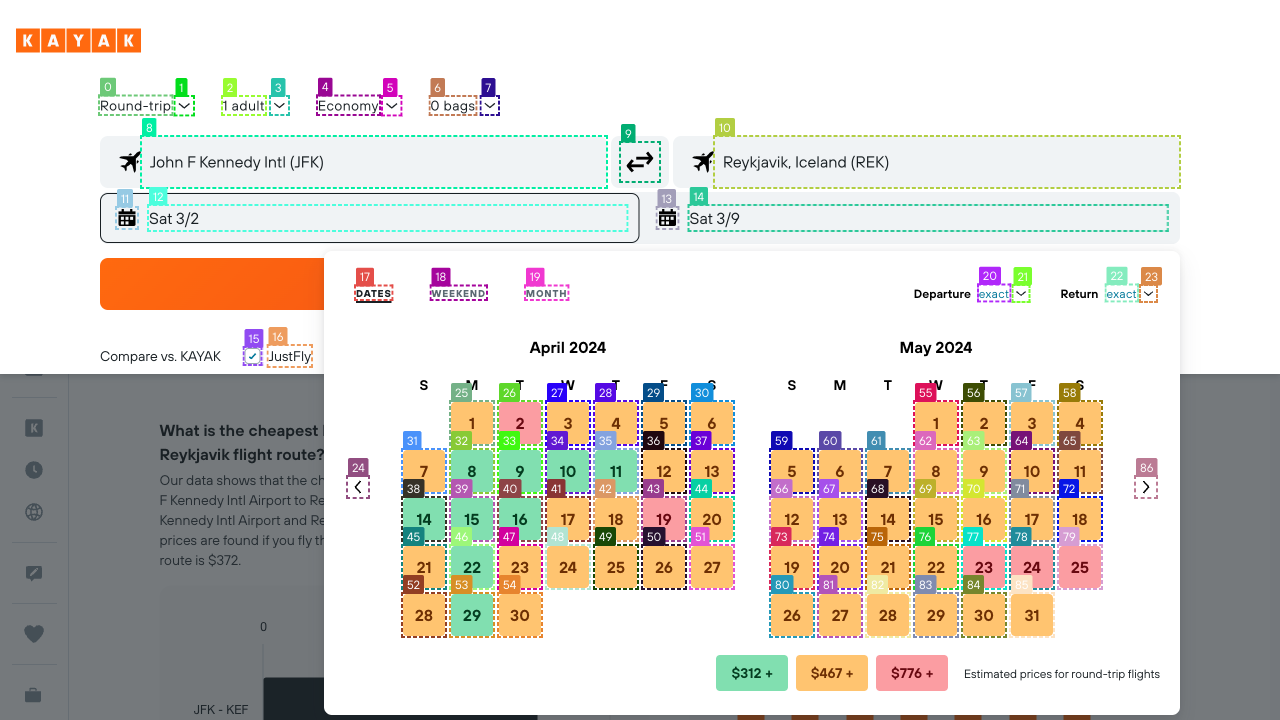

Final response: The best prices for a one-way flight from New York to Reykjavik over the next two months are $312+ on April 30th, $467+ on May 1st, and $776+ on May 2nd.


In [36]:
res = await call_agent(
    "Search a one-way flight from New York To Rejkavik for"
    " 1 Adult and analyse the price graph for the"
    " next 2 months",
    page,
)
print(f"Final response: {res}")